In [22]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [23]:
# Change the current working directory to the notebooks folder
os.chdir(r'C:\Users\A070050\OneDrive - Tata Steel Europe Ltd\Documents\notebooks')

data_file_path = r'..\dvl-data'  # Use relative path to dvl-data

In [24]:
file_name = '2024-04-04_DVL1_test_data_for_refit.csv'
full_path = os.path.join(data_file_path, file_name)

dvl1 = pd.read_csv(full_path, delimiter=',')
dvl1 = dvl1[dvl1['r_value'] != 0]

# full_path = '/Users/tonny/Desktop/tata_thesis_stage/dvl/2024-04-04_DVL1_test_data_for_refit.csv'
# dvl1 = pd.read_csv(full_path, delimiter=',')
# dvl1 = dvl1[dvl1['r_value'] != 0]

In [25]:
def map_steel_family(df):

    family_mapping = {
        # AHSS family
        '2F63': 'AHSS',
        '2F95': 'AHSS',
        '2Q91': 'AHSS',
        '3F63': 'AHSS',
        
        # CMn family
        '110E': 'CMn', '110F': 'CMn', '110H': 'CMn', '112H': 'CMn', 
        '112L': 'CMn', '114E': 'CMn', '116L': 'CMn', '125C': 'CMn',
        '126C': 'CMn', '126L': 'CMn', '180L': 'CMn', '180N': 'CMn',
        '184L': 'CMn', '184M': 'CMn', '186C': 'CMn', '187L': 'CMn',
        '180G': 'CMn', '111C': 'CMn', '114C': 'CMn', '114H': 'CMn',
        '121L': 'CMn', '1T46': 'CMn', '1T36': 'CMn', '1T86': 'CMn',
        '1S38': 'CMn', '1S42': 'CMn', '1T32': 'CMn', '1T80': 'CMn',
        '1T82': 'CMn', '1T34': 'CMn', '110B': 'CMn', '1P65': 'CMn',
        '184K': 'CMn', '1N47': 'CMn', '1N57': 'CMn', '123L': 'CMn',
        '115H': 'CMn', '1T44': 'CMn', '1T84': 'CMn', '1T94': 'CMn', 
        '115E': 'CMn', '1P85': 'CMn', 
        
        # HSLA family
        '1N80': 'HSLA', '1N31': 'HSLA', '1N60': 'HSLA', '1N61': 'HSLA',
        '1N81': 'HSLA', '1N91': 'HSLA', '1N84': 'HSLA', '1N64': 'HSLA',
        '1N94': 'HSLA', '1N32': 'HSLA', '1N33': 'HSLA', '1N62': 'HSLA',
        '1N63': 'HSLA', '1N82': 'HSLA', '1N83': 'HSLA', '1N92': 'HSLA',
        '1N93': 'HSLA', '1N36': 'HSLA', '1N37': 'HSLA', '1N66': 'HSLA',
        '1N67': 'HSLA', '1N86': 'HSLA', '1N87': 'HSLA', '1N96': 'HSLA',
        '1N97': 'HSLA', '1N38': 'HSLA', '1N39': 'HSLA', '1N68': 'HSLA',
        '1N69': 'HSLA', '1N88': 'HSLA', '1N98': 'HSLA', '1N99': 'HSLA',
        '3N73': 'HSLA', '3N73': 'HSLA',
        
        # IF family
        '514Z': 'IF', '515M': 'IF', '581G': 'IF', '590Q': 'IF',
        '590Z': 'IF', '591M': 'IF', '594Q': 'IF', '594Z': 'IF',
        '595M': 'IF', '542P': 'IF', '543P': 'IF', '544P': 'IF',
        '545P': 'IF', '540Z': 'IF', '541M': 'IF', '54AE': 'IF',
        '561P': 'IF', '592P': 'IF', '593P': 'IF', '598P': 'IF',
        '599P': 'IF', '59AD': 'IF', '552V': 'IF', '553V': 'IF',
        '589L': 'IF', '59TM': 'IF', '55AV': 'IF'
    }
    
    df_copy = df.copy()
    
    # Map steel family on the copy
    df_copy['steel_family'] = df_copy['steel_grade'].map(family_mapping)
    
    return df_copy

In [26]:
def remove_outliers(df):
    Q1 = df['r_value'].quantile(0.10)
    Q3 = df['r_value'].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df['r_value'] >= lower_bound) & (df['r_value'] <= upper_bound)]

In [27]:
dvl1 = map_steel_family(dvl1)
dvl1['steel_family'].value_counts()

steel_family
IF      6094
HSLA    5712
CMn     3901
Name: count, dtype: int64

In [29]:
# desc[(desc['model'] != 'n') are relevant features, these are handlabeled with my supervisor

path = '/Users/A070050/Tata Steel Europe Ltd/R&D NL Data Driven Steel - U3-2 r-value model/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
# path = '/Users/tonny/Desktop/tata_thesis_stage/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
desc = pd.read_excel(path, sheet_name=3)

tmp = desc[(desc['model'] != 'n') & (desc['Table Name'] == 'mecomep_dv21') 
             & ((desc['Input Type'] == 'Actual - Measurement or Count') | (desc['Input Type'] == 'Prediction - Calculation'))]
features_selected = tmp[['Attribute Name', 'Input Type']]

existing_columns = [col for col in features_selected['Attribute Name'] if col in dvl1.columns]
dvl1_selected = dvl1[existing_columns+['r_value', 'steel_grade']]

c:\Users\A070050\AppData\Local\Programs\Python\Python38\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [30]:
nan_cols = dvl1_selected.isna().sum().sort_values(ascending=False)
nan_cols = nan_cols[nan_cols > 0] #columns with no nan are not relevant
cols_to_drop = nan_cols[nan_cols > 100].index.tolist()
dvl1_selected = dvl1_selected.drop(cols_to_drop, axis=1)
dvl1_selected.dropna(inplace=True)

In [31]:
corr_threshold = 0.2

corr = dvl1_selected.drop(['steel_grade'], axis=1).corr()['r_value'].abs()
selected_features = corr[abs(corr) >= corr_threshold].index.tolist()

print(f'dropped {len(dvl1_selected.columns) - len(selected_features)} columns')

dropped 24 columns


In [32]:
# Dropping steelgrade occurences that dont appear often (less than 5)
dvl1_selected = dvl1_selected[selected_features+['steel_grade']]
counts = dvl1_selected['steel_grade'].value_counts()
filtered_values = counts[counts >= 5].index
dvl1_selected = dvl1_selected[dvl1_selected['steel_grade'].isin(filtered_values)]
dvl1_selected = map_steel_family(dvl1_selected).drop(['steel_grade'], axis=1)
dvl1_selected = dvl1_selected.groupby('steel_family').apply(remove_outliers).reset_index(drop=True)

dvl1_selected

,cold_roll_reduction,elong_tl_pct,elong_tm_pct,gauge_f1,gauge_f2,gauge_f3,gauge_f4,gauge_f5,gauge_f6,gauge_f7,...,tension_tm_exit_mpa,time_inter_f1,time_inter_f2,time_inter_f3,time_inter_f4,time_inter_f5,time_inter_f6,time_inter_f7,r_value,steel_family
0,66.97,2.0,16.0,24.529786,16.663215,11.979636,9.008755,6.573885,5.513293,4.56455,...,81.0,38.100,3.690,2.400,1.710,1.300,1.050,0.850,1.15,CMn
1,67.88,2.0,0.0,26.053005,18.053067,12.849053,9.586975,7.760840,6.249673,4.72489,...,118.0,39.484,4.328,2.860,2.009,1.481,1.179,0.862,1.05,CMn
2,67.90,2.0,16.0,24.351294,16.750388,12.294898,9.102001,6.660000,5.530000,4.70891,...,81.0,44.838,4.530,2.960,2.029,1.516,1.229,1.005,1.15,CMn
3,72.38,2.0,16.0,21.690000,12.760000,8.450000,5.960000,4.410000,3.450000,2.90239,...,90.0,72.496,3.640,2.051,1.351,0.940,0.684,0.542,1.05,CMn
4,72.38,2.0,16.0,20.780000,12.730000,8.530000,5.900000,4.410000,3.440000,2.89543,...,90.0,72.272,3.531,2.006,1.330,0.934,0.687,0.545,1.05,CMn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15591,78.13,1.0,15.0,26.590000,17.980000,12.760000,9.440000,7.160000,5.550000,3.80039,...,36.0,68.653,2.569,1.715,1.213,0.882,0.673,0.514,1.50,IF
15592,73.90,1.0,13.0,28.973028,20.959475,15.100574,11.654747,9.185976,7.139899,5.76871,...,47.0,34.770,2.870,2.030,1.470,1.120,0.870,0.700,1.65,IF
15593,80.32,1.0,15.0,26.670000,17.900000,12.060000,8.490000,6.530000,5.120000,4.37135,...,45.0,45.712,3.167,2.076,1.411,0.996,0.755,0.582,2.20,IF
15594,80.32,1.0,15.0,27.028830,18.710170,12.928046,9.371886,7.225700,5.603521,4.39936,...,49.0,35.765,3.247,2.170,1.481,1.049,0.790,0.610,2.15,IF


In [33]:
# labeling the features for each branch
features = [col for col in dvl1_selected.columns if col not in ['r_value', 'steel_family']]
features_dict = {
   'time': [col for col in features if 'time' in col.lower()], 
   'chemical': ['pct_al', 'pct_b', 'pct_c', 'pct_cr', 'pct_mn', 'pct_n', 'pct_nb', 'pct_si', 'pct_ti', 'pct_v', 'mfia_coil_frac_fer', 'mfia_et1_frac_fer', 'mfia_et2_frac_fer'],
}
features_dict['process'] = [col for col in features if col not in features_dict['time'] and col not in features_dict['chemical']]

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split first to avoid data leakage
train_df, test_df = train_test_split(dvl1_selected, test_size=0.2, random_state=42)

# Scale the training set
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(['steel_family'], axis=1))
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop(['steel_family'], axis=1).columns)
train_scaled_df['steel_family'] = train_df['steel_family'].reset_index(drop=True)

# Scale the testing set using the scaler fitted on the training set
test_scaled = scaler.transform(test_df.drop(['steel_family'], axis=1))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop(['steel_family'], axis=1).columns)
test_scaled_df['steel_family'] = test_df['steel_family'].reset_index(drop=True)

In [35]:
class MultiBranchSteelRegressor(nn.Module):
    def __init__(self, chemical_dim, time_dim, process_dim, hidden_units=64, dropout_rate=0.2):
        super().__init__()
        
        # Track which branches are active
        self.has_chemical = chemical_dim > 0
        self.has_time = time_dim > 0
        self.has_process = process_dim > 0
        
        # Count active branches
        self.active_branches = sum([self.has_chemical, self.has_time, self.has_process])
        
        # Adjust hidden units for each branch
        self.branch_hidden = min(hidden_units, max(16, hidden_units // 2))
        
        # Creating branch
        def create_branch(input_dim):
            return nn.Sequential(
                nn.Linear(input_dim, self.branch_hidden),
                nn.BatchNorm1d(self.branch_hidden),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
        
        # Only create branches that have features
        if self.has_chemical:
            self.chemical_branch = create_branch(chemical_dim)
        if self.has_time:
            self.time_branch = create_branch(time_dim)
        if self.has_process:
            self.process_branch = create_branch(process_dim)
        
        # Combined input dimension based on active branches only
        combined_dim = self.branch_hidden * self.active_branches
        
        # Final layers after concatenation
        self.final_layers = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )

    def forward(self, chemical, time, process):
        features = []
        
        # Only process branches that have features
        if self.has_chemical:
            if chemical.dim() == 1:
                chemical = chemical.unsqueeze(0)
            features.append(self.chemical_branch(chemical))
        
        if self.has_time:
            if time.dim() == 1:
                time = time.unsqueeze(0)
            features.append(self.time_branch(time))
        
        if self.has_process:
            if process.dim() == 1:
                process = process.unsqueeze(0)
            features.append(self.process_branch(process))
        
        # Concatenate only active features
        combined = torch.cat(features, dim=1) if len(features) > 1 else features[0]
        return self.final_layers(combined)

In [36]:
class EnhancedMultiBranchRegressor(nn.Module):
    def __init__(self, chemical_dim, time_dim, process_dim, hyperparameters=None):
        super().__init__()

        default_params = {
            'batch_size': 32,
            'hidden_units': 64,
            'dropout_rate': 0.2,
            'cross_branch_dropout': 0,
            'final_layer_units': [128, 64],
            'final_layer_dropout': [0, 0],
            'activation': nn.ReLU(),
            'normalization': 'layer',
            'l2_lambda': 0.001,
            'residual_blocks': 2  # Number of residual blocks per branch
        }
        # Merge default and provided hyperparameters
        self.hp = {**default_params, **(hyperparameters or {})}

        def get_normalization(units):
            """Select normalization layer based on configuration."""
            if self.hp['normalization'] == 'batch':
                return nn.BatchNorm1d(units)
            elif self.hp['normalization'] == 'layer':
                return nn.LayerNorm(units)
            else:
                return nn.Identity()

        def create_residual_block(input_dim):
            """Create a residual block with adaptive configuration."""
            return ResidualBlock(
                input_dim, 
                self.hp['hidden_units'], 
                activation=self.hp['activation'], 
                dropout_rate=self.hp['dropout_rate'],
                normalization_func=get_normalization
            )

        def create_residual_branch(input_dim):
            """Create a residual branch with multiple blocks."""
            if input_dim <= 0:
                return None
            
            blocks = []
            # Initial projection layer
            blocks.append(nn.Linear(input_dim, self.hp['hidden_units']))
            blocks.append(get_normalization(self.hp['hidden_units']))
            blocks.append(self.hp['activation'])

            # Add residual blocks
            for _ in range(self.hp['residual_blocks']):
                blocks.append(create_residual_block(self.hp['hidden_units']))
            
            return nn.Sequential(*blocks)

        # Residual Branches
        self.branches = nn.ModuleDict({
            'chemical': create_residual_branch(chemical_dim),
            'time': create_residual_branch(time_dim),
            'process': create_residual_branch(process_dim)
        })

        # Cross-branch interaction
        active_branches = sum(1 for branch in self.branches.values() if branch is not None)
        cross_input_dim = self.hp['hidden_units'] * active_branches

        # Cross-branch interaction with residual connection
        self.cross_branch_interaction = nn.Sequential(
            nn.Linear(cross_input_dim, cross_input_dim // 2),
            self.hp['activation'],
            nn.Dropout(self.hp['cross_branch_dropout'])
        )

        # Dynamic final layers based on hyperparameters
        final_layers = []
        prev_units = cross_input_dim // 2
        for units, dropout_rate in zip(self.hp['final_layer_units'], self.hp['final_layer_dropout']):
            final_layers.extend([
                nn.Linear(prev_units, units),
                get_normalization(units),
                self.hp['activation'],
                nn.Dropout(dropout_rate)
            ])
            prev_units = units
        final_layers.append(nn.Linear(prev_units, 1))
        self.final_layers = nn.Sequential(*final_layers)

    def forward(self, chemical, time, process):
        processed_branches = []
        for name, input_tensor, branch in zip(
            ['chemical', 'time', 'process'],
            [chemical, time, process],
            [self.branches['chemical'], self.branches['time'], self.branches['process']]
        ):
            if branch is not None:
                processed_branches.append(branch(input_tensor))
        
        # Cross-branch interaction
        if len(processed_branches) > 1:
            cross_branch_features = torch.cat(processed_branches, dim=1)
            interaction_features = self.cross_branch_interaction(cross_branch_features)
        else:
            interaction_features = processed_branches[0]
        
        return self.final_layers(interaction_features)


class ResidualBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation=nn.ReLU(), 
                 dropout_rate=0.2, normalization_func=None):
        super().__init__()
        
        # Use provided normalization function or default to Identity
        norm_func = normalization_func(hidden_dim) if normalization_func else nn.Identity()
        
        # Residual block with two linear layers
        self.block = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            norm_func,
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            norm_func
        )
        
        # Shortcut connection
        if input_dim != hidden_dim:
            self.shortcut = nn.Linear(input_dim, hidden_dim)
        else:
            self.shortcut = nn.Identity()
        
        # Final activation
        self.activation = activation

    def forward(self, x):
        # Residual connection
        residual = self.shortcut(x)
        out = self.block(x)
        
        # Combine residual and transformed features
        combined = residual + out
        return self.activation(combined)

In [37]:
def train_family_models_enhanced(df, features_dict, num_epochs, hyperparameters):
    family_models = {}
    evaluation_results = {}
    batch_size = hyperparameters['batch_size']

    for family in df['steel_family'].unique():
        family_data = df[df['steel_family'] == family].drop(['steel_family'], axis=1)

        # Initialize feature arrays and dimensions
        feature_arrays = {}
        feature_dims = {}

        # Process each feature category
        for category in ['chemical', 'time', 'process']:
            available_features = [col for col in features_dict[category] 
                                if col in family_data.columns]

            if available_features:
                # Scale each feature category independently
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
                feature_dims[category] = len(available_features)
            else:
                feature_arrays[category] = np.zeros((len(family_data), 0))  # Empty array
                feature_dims[category] = 0

        # Prepare targets
        targets = family_data['r_value'].values

        # Split data
        split_data = train_test_split(
            feature_arrays['chemical'],
            feature_arrays['time'],
            feature_arrays['process'],
            targets,
            test_size=0.2,
            random_state=42
        )

        (X_train_chem, X_test_chem, X_train_time, X_test_time, 
         X_train_proc, X_test_proc, y_train, y_test) = split_data

        # Convert to tensors
        train_tensors = {
            'chemical': torch.FloatTensor(X_train_chem),
            'time': torch.FloatTensor(X_train_time),
            'process': torch.FloatTensor(X_train_proc)
        }

        test_tensors = {
            'chemical': torch.FloatTensor(X_test_chem),
            'time': torch.FloatTensor(X_test_time),
            'process': torch.FloatTensor(X_test_proc)
        }

        y_train_tensor = torch.FloatTensor(y_train)
        y_test_tensor = torch.FloatTensor(y_test)

        # Create DataLoader
        train_dataset = TensorDataset(
            train_tensors['chemical'],
            train_tensors['time'],
            train_tensors['process'],
            y_train_tensor
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)

        # Initialize model
        model = EnhancedMultiBranchRegressor(
            chemical_dim=feature_dims['chemical'],
            time_dim=feature_dims['time'], 
            process_dim=feature_dims['process'],
            hyperparameters={
                'hidden_units': hyperparameters['hidden_units'],
                'dropout_rate': hyperparameters['dropout_rate'],
                'learning_rate': hyperparameters['learning_rate']
            }
        )

        optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=hyperparameters['learning_rate'],
        weight_decay=hyperparameters.get('l2_lambda', 0.001)  # L2 regularization
        )
        criterion = nn.L1Loss()

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for batch_chem, batch_time, batch_proc, batch_targets in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_chem, batch_time, batch_proc)
                loss = criterion(outputs, batch_targets.unsqueeze(1))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred = model(
                test_tensors['chemical'],
                test_tensors['time'],
                test_tensors['process']
            )   
            test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1)).item()
            y_pred_np = y_pred.numpy().flatten()
            r2 = r2_score(y_test, y_pred_np)

            evaluation_results[family] = {
                'test_loss': test_loss,
                'r2_score': r2
            }
            print(f"Evaluation for {family} - Test Loss: {test_loss:.4f}, R2: {r2:.4f}")

        family_models[family] = model

    return family_models, evaluation_results

In [38]:
def train_family_models_regular(df, features_dict, num_epochs, hyperparameters, use_l2=False):
    family_models = {}
    evaluation_results = {}
    batch_size = hyperparameters['batch_size']

    for family in df['steel_family'].unique():
        family_data = df[df['steel_family'] == family].drop(['steel_family'], axis=1)


        # Initialize feature arrays and dimensions
        feature_arrays = {}
        feature_dims = {}

        # Process each feature category
        for category in ['chemical', 'time', 'process']:
            available_features = [col for col in features_dict[category] 
                                if col in family_data.columns]

            if available_features:
                # Scale each feature category independently
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
                feature_dims[category] = len(available_features)
            else:
                feature_arrays[category] = np.zeros((len(family_data), 0))  # Empty array
                feature_dims[category] = 0

        # Prepare targets
        targets = family_data['r_value'].values

        # Split data
        split_data = train_test_split(
            feature_arrays['chemical'],
            feature_arrays['time'],
            feature_arrays['process'],
            targets,
            test_size=0.2,
            random_state=42
        )

        (X_train_chem, X_test_chem, X_train_time, X_test_time, 
         X_train_proc, X_test_proc, y_train, y_test) = split_data

        # Convert to tensors
        train_tensors = {
            'chemical': torch.FloatTensor(X_train_chem),
            'time': torch.FloatTensor(X_train_time),
            'process': torch.FloatTensor(X_train_proc)
        }

        test_tensors = {
            'chemical': torch.FloatTensor(X_test_chem),
            'time': torch.FloatTensor(X_test_time),
            'process': torch.FloatTensor(X_test_proc)
        }

        y_train_tensor = torch.FloatTensor(y_train)
        y_test_tensor = torch.FloatTensor(y_test)

        # Create DataLoader
        train_dataset = TensorDataset(
            train_tensors['chemical'],
            train_tensors['time'],
            train_tensors['process'],
            y_train_tensor
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        # Initialize model
        model = MultiBranchSteelRegressor(
            chemical_dim=feature_dims['chemical'],
            time_dim=feature_dims['time'],
            process_dim=feature_dims['process'],
            hidden_units=hyperparameters['hidden_units'],
            dropout_rate=hyperparameters['dropout_rate']
        )
        if use_l2:
            weight_decay=0.001
        else:
            weight_decay=0.0
        optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay)
        criterion = nn.L1Loss()

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for batch_chem, batch_time, batch_proc, batch_targets in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_chem, batch_time, batch_proc)
                loss = criterion(outputs, batch_targets.unsqueeze(1))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred = model(
                test_tensors['chemical'],
                test_tensors['time'],
                test_tensors['process']
            )
            test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1)).item()
            y_pred_np = y_pred.numpy().flatten()
            r2 = r2_score(y_test, y_pred_np)
            
            evaluation_results[family] = {
                'test_loss': test_loss,
                'r2_score': r2
            }
            print(f"Evaluation for {family} - Test Loss: {test_loss:.4f}, R2: {r2:.4f}")

        family_models[family] = model

    return family_models, evaluation_results

In [39]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [1e-3],
    'batch_size': [32, 64],
    'hidden_units': [64, 128],
    'dropout_rate': [0, 0.2],
    'cross_branch_dropout': [0, 0.2],
    'final_layer_units': [
        [128, 64],
        [256, 128],
    ],
    'final_layer_dropout': [
        [0, 0],
        [0.2, 0.2],
    ],
    'normalization': ['batch', 'layer']
}
grid = ParameterGrid(param_grid)

In [40]:
# from tqdm import tqdm

# num_epochs = 50

# best_results = {}
# best_params = None

# for params in tqdm(grid, desc="Grid Search Progress", leave=True):
#     print(f"\nEvaluating hyperparameters: {params}")
    
#     family_models, evaluation_results = train_family_models_enhanced(train_df, features_dict, num_epochs, params)
    
#     avg_r2 = np.mean([evaluation_results[family]['r2_score'] for family in evaluation_results])
    
#     if best_params is None or avg_r2 > best_results['avg_r2']:
#         best_results = {
#             'avg_r2': avg_r2,
#             'evaluation_results': evaluation_results
#         }
#         best_params = params

#     print(f"Average R2 Score: {avg_r2:.4f}")

# print(f"\nBest Hyperparameters: {best_params}")
# print(f"Best R2 Score: {best_results['avg_r2']:.4f}")


In [41]:
# best_results = {'avg_r2': 0.5774655195501973,
#  'evaluation_results': {'CMn': {'test_loss': 0.057762887328863144,
#    'r2_score': 0.543479086418242},
#   'HSLA': {'test_loss': 0.024983583018183708, 'r2_score': 0.718411446680632},
#   'IF': {'test_loss': 0.12141738831996918, 'r2_score': 0.47050602555171783}}}

In [42]:
best_params_grid = {'batch_size': 32,
 'cross_branch_dropout': 0,
 'dropout_rate': 0.2,
 'final_layer_dropout': [0, 0],
 'final_layer_units': [128, 64],
 'hidden_units': 64,
 'learning_rate': 0.001,
 'normalization': 'layer'}

In [43]:
best_params = {'batch_size': 32,
 'dropout_rate': 0.2,
 'hidden_units': 64,
 'learning_rate': 0.001,
}

In [44]:
family_models, eval = train_family_models_regular(train_scaled_df, features_dict, 100, best_params, use_l2=True)

Epoch [10/100], Loss: 0.1976
Epoch [20/100], Loss: 0.1816
Epoch [30/100], Loss: 0.1778
Epoch [40/100], Loss: 0.1732
Epoch [50/100], Loss: 0.1691
Epoch [60/100], Loss: 0.1665
Epoch [70/100], Loss: 0.1639
Epoch [80/100], Loss: 0.1650
Epoch [90/100], Loss: 0.1581
Epoch [100/100], Loss: 0.1576
Evaluation for CMn - Test Loss: 0.1630, R2: 0.5757
Epoch [10/100], Loss: 0.2629
Epoch [20/100], Loss: 0.2531
Epoch [30/100], Loss: 0.2442
Epoch [40/100], Loss: 0.2410
Epoch [50/100], Loss: 0.2370
Epoch [60/100], Loss: 0.2354
Epoch [70/100], Loss: 0.2299
Epoch [80/100], Loss: 0.2292
Epoch [90/100], Loss: 0.2280
Epoch [100/100], Loss: 0.2293
Evaluation for IF - Test Loss: 0.2466, R2: 0.4817
Epoch [10/100], Loss: 0.1652
Epoch [20/100], Loss: 0.1421
Epoch [30/100], Loss: 0.1366
Epoch [40/100], Loss: 0.1283
Epoch [50/100], Loss: 0.1281
Epoch [60/100], Loss: 0.1240
Epoch [70/100], Loss: 0.1234
Epoch [80/100], Loss: 0.1214
Epoch [90/100], Loss: 0.1184
Epoch [100/100], Loss: 0.1172
Evaluation for HSLA - Test

In [45]:
eval

{'CMn': {'test_loss': 0.16302154958248138, 'r2_score': 0.575736893555643},
 'IF': {'test_loss': 0.24663962423801422, 'r2_score': 0.4816835240523425},
 'HSLA': {'test_loss': 0.10485411435365677, 'r2_score': 0.735691460047552}}

In [ ]:
# def plot_actual_vs_predicted(df, family_models, features_dict):
#     families = df['steel_family'].unique()
#     num_families = len(families)
#     rows = (num_families + 1) // 2
    
#     plt.figure(figsize=(10, 4 * rows))
    
#     for idx, family in enumerate(families, 1):
#         family_data = df[df['steel_family'] == family].drop(['steel_family'], axis=1)
#         feature_arrays = {}
#         for category in ['chemical', 'time', 'process']:
#             available_features = [col for col in features_dict[category] 
#                                   if col in family_data.columns]
#             if available_features:
#                 scaler = StandardScaler()
#                 feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
#             else:
#                 feature_arrays[category] = np.zeros((len(family_data), 0))
        
#         chemical_tensor = torch.FloatTensor(feature_arrays['chemical'])
#         time_tensor = torch.FloatTensor(feature_arrays['time'])
#         process_tensor = torch.FloatTensor(feature_arrays['process'])
        
#         with torch.no_grad():
#             predicted = family_models[family](
#                 chemical_tensor, 
#                 time_tensor, 
#                 process_tensor
#             ).numpy().flatten()
        
#         actual = family_data['r_value'].values
#         r2 = r2_score(actual, predicted)
#         mae = mean_absolute_error(actual, predicted)
        
#         plt.subplot(rows, 2, idx)
#         plt.scatter(actual, predicted, alpha=0.5)
#         m, b = np.polyfit(actual, predicted, 1)
#         plt.plot(actual, m*actual + b, color='red', linestyle='--')
#         plt.plot([actual.min(), actual.max()], 
#                  [actual.min(), actual.max()], 
#                  color='green', linestyle=':')
        
#         buffer = 0.2
#         x_min, x_max = actual.min() - (actual.max() - actual.min()) * buffer, actual.max() + (actual.max() - actual.min()) * buffer
#         y_min, y_max = predicted.min() - (predicted.max() - predicted.min()) * buffer, predicted.max() + (predicted.max() - predicted.min()) * buffer
#         plt.xlim(x_min, x_max)
#         plt.ylim(y_min, y_max)
        
#         plt.xlabel('Actual R-value')
#         plt.ylabel('Predicted R-value')
#         plt.title(f'{family} Family\nR² = {r2:.4f}, MAE = {mae:.4f}')
#         plt.axis('equal')
    
#     plt.tight_layout(pad=2.0, w_pad=1.5, h_pad=3.0)
#     plt.show()

In [74]:
def plot_actual_vs_predicted(df, family_models, features_dict):
    families = df['steel_family'].unique()
    
    for family in families:
        # Filter data for the current family
        family_data = df[df['steel_family'] == family].drop(['steel_family'], axis=1)
        
        # Prepare feature arrays
        feature_arrays = {}
        for category in ['chemical', 'time', 'process']:
            available_features = [col for col in features_dict[category] 
                                  if col in family_data.columns]
            if available_features:
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
            else:
                feature_arrays[category] = np.zeros((len(family_data), 0))
        
        # Convert features to tensors
        chemical_tensor = torch.FloatTensor(feature_arrays['chemical'])
        time_tensor = torch.FloatTensor(feature_arrays['time'])
        process_tensor = torch.FloatTensor(feature_arrays['process'])
        
        # Make predictions
        with torch.no_grad():
            predicted = family_models[family](
                chemical_tensor, 
                time_tensor, 
                process_tensor
            ).numpy().flatten()
        
        # Get actual values
        actual = family_data['r_value'].values
        
        # Calculate metrics
        r2 = r2_score(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        
        # Create a new figure for each family
        plt.figure(figsize=(10, 8))
        
        # Scatter plot
        plt.scatter(actual, predicted, alpha=0.5)
        
        # Linear regression line
        m, b = np.polyfit(actual, predicted, 1)
        plt.plot(actual, m*actual + b, color='red', linestyle='--', label='Regression Line')
        
        # Perfect prediction line
        plt.plot([actual.min(), actual.max()], 
                 [actual.min(), actual.max()], 
                 color='green', linestyle=':', label='Perfect Prediction')
        
        # Set plot limits with buffer
        buffer = 0.2
        x_min, x_max = actual.min() - (actual.max() - actual.min()) * buffer, actual.max() + (actual.max() - actual.min()) * buffer
        y_min, y_max = predicted.min() - (predicted.max() - predicted.min()) * buffer, predicted.max() + (predicted.max() - predicted.min()) * buffer
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        
        # Labeling
        plt.xlabel('Actual R-value')
        plt.ylabel('Predicted R-value')
        plt.title(f'{family} Family\nR² = {r2:.4f}, MAE = {mae:.4f}')
        plt.axis('equal')
        plt.legend()
        
        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()

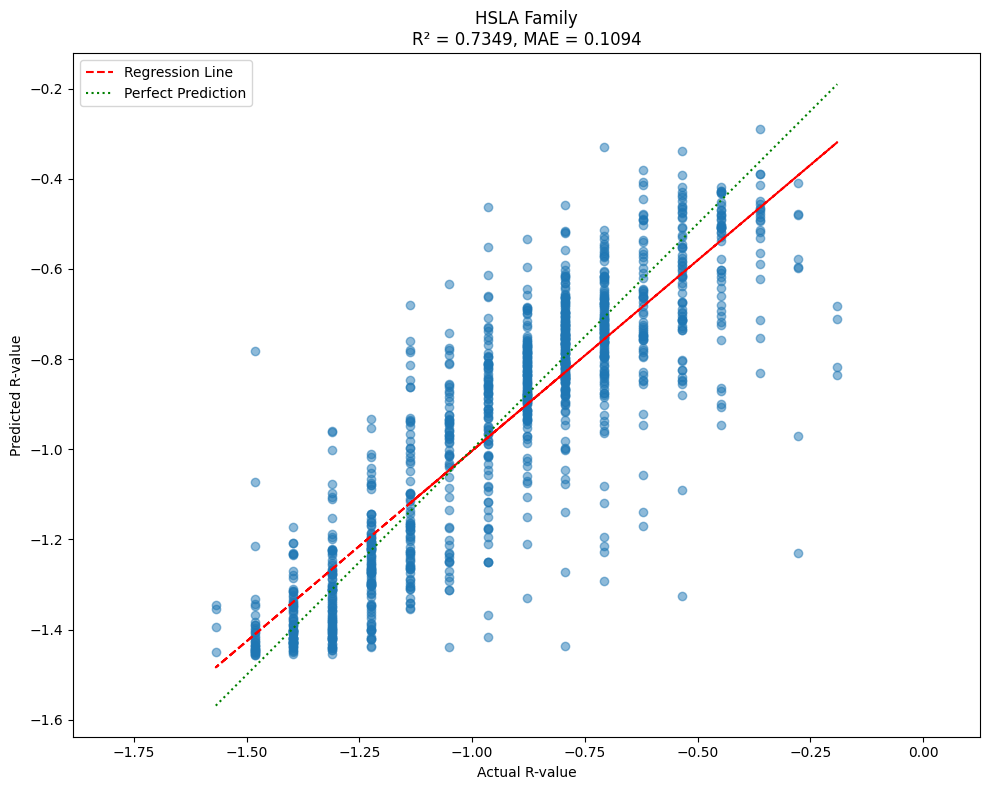

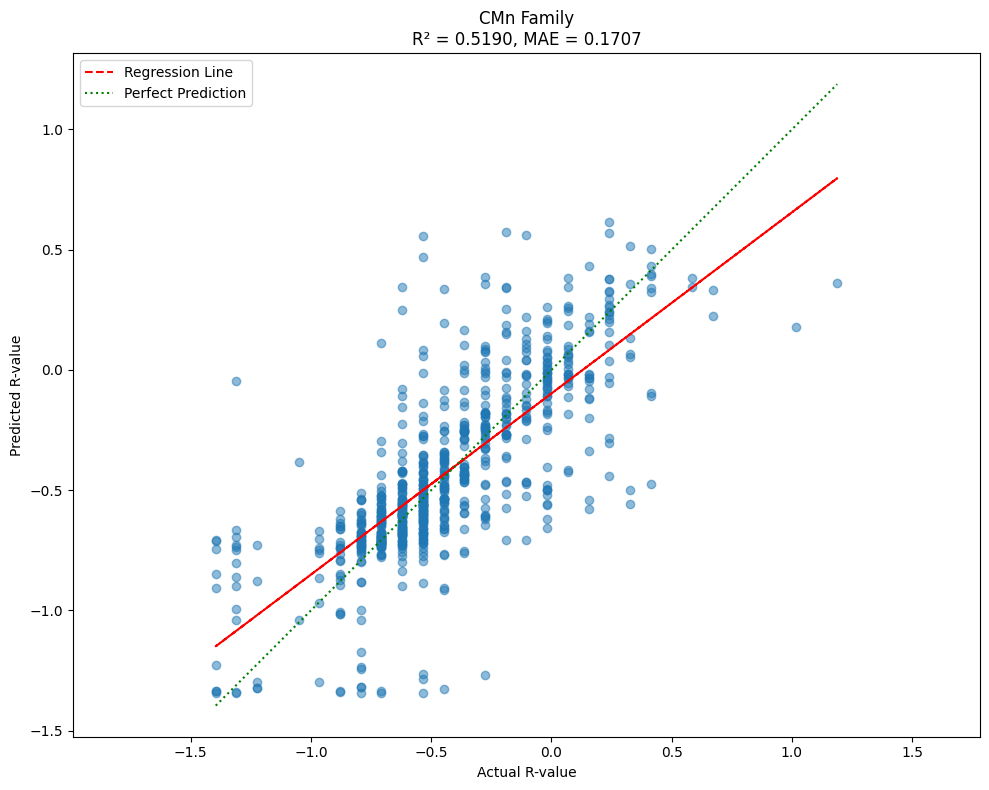

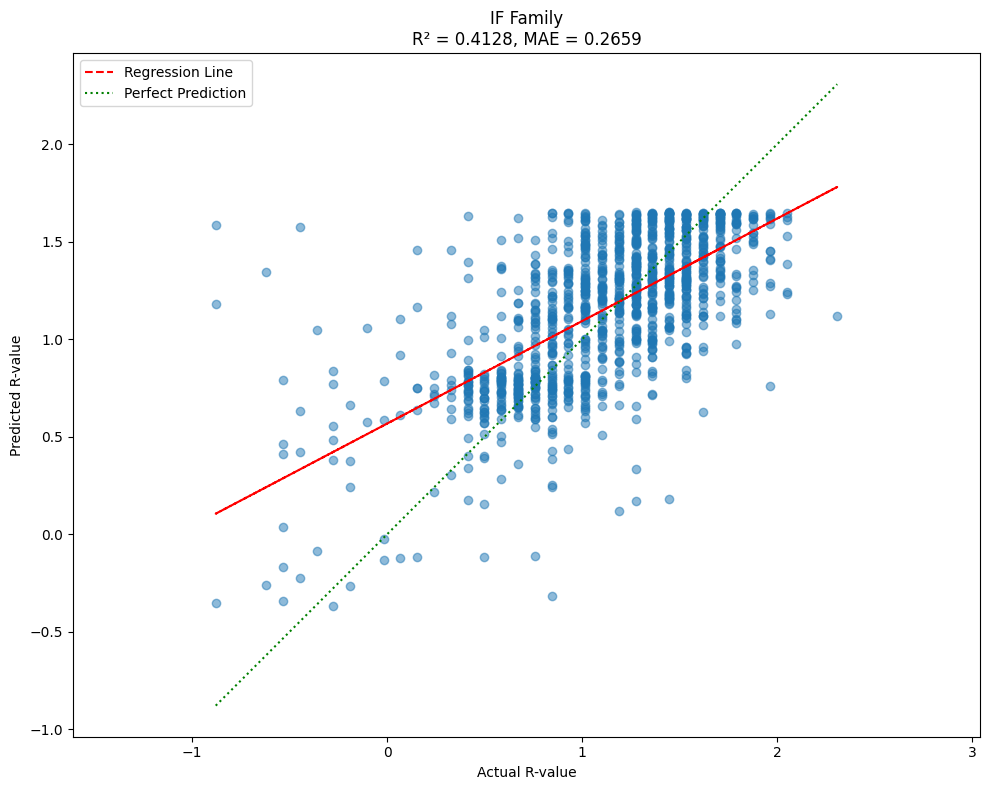

In [75]:
plot_actual_vs_predicted(test_scaled_df, family_models, features_dict)

In [48]:
best_params = {'batch_size': 32,
 'dropout_rate': 0.2,
 'hidden_units': 64,
 'learning_rate': 0.001,
 'l2_lambda': 0.001
}

In [ ]:
family_models_enhanced, eval = train_family_models_enhanced(train_scaled_df, features_dict, 100, best_params_grid)

Epoch [10/100], Loss: 0.1662
Epoch [20/100], Loss: 0.1531
Epoch [30/100], Loss: 0.1481
Epoch [40/100], Loss: 0.1369
Epoch [50/100], Loss: 0.1335
Epoch [60/100], Loss: 0.1264
Epoch [70/100], Loss: 0.1195
Epoch [80/100], Loss: 0.1074
Epoch [90/100], Loss: 0.1058
Epoch [100/100], Loss: 0.1017
Evaluation for CMn - Test Loss: 0.1642, R2: 0.5248
Epoch [10/100], Loss: 0.2360
Epoch [20/100], Loss: 0.2254
Epoch [30/100], Loss: 0.2194
Epoch [40/100], Loss: 0.2144
Epoch [50/100], Loss: 0.2079
Epoch [60/100], Loss: 0.2039
Epoch [70/100], Loss: 0.1994
Epoch [80/100], Loss: 0.1948
Epoch [90/100], Loss: 0.1842
Epoch [100/100], Loss: 0.1815
Evaluation for IF - Test Loss: 0.2586, R2: 0.4237
Epoch [10/100], Loss: 0.1131
Epoch [20/100], Loss: 0.1058
Epoch [30/100], Loss: 0.1027
Epoch [40/100], Loss: 0.0985
Epoch [50/100], Loss: 0.0960
Epoch [60/100], Loss: 0.0923


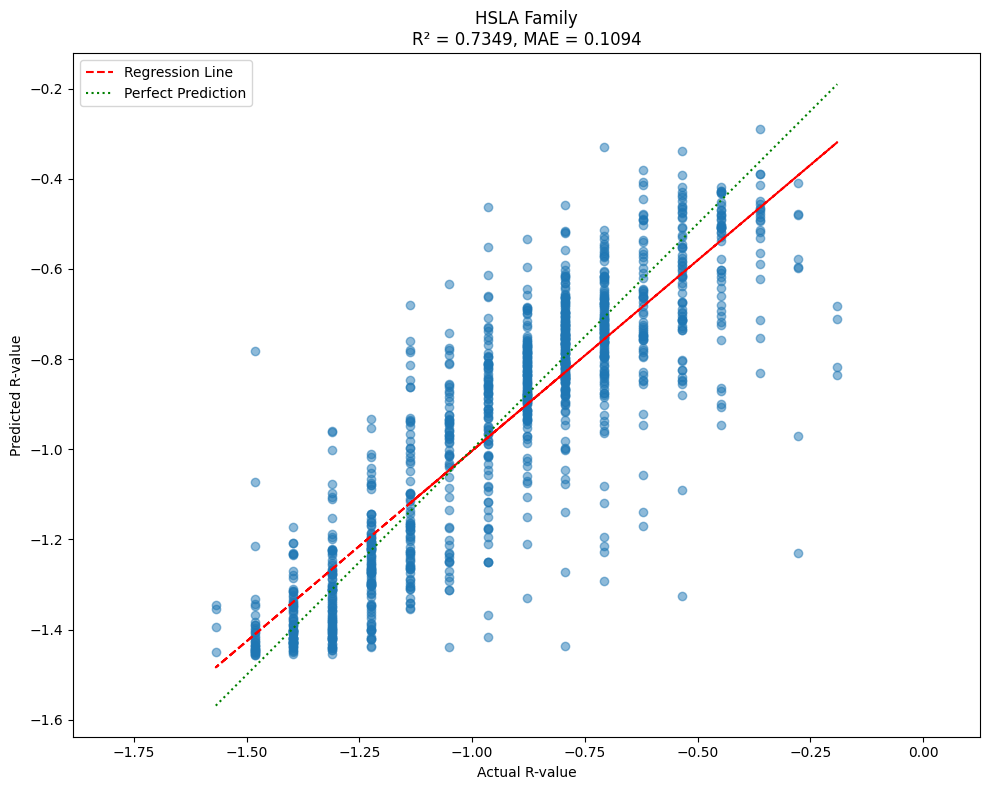

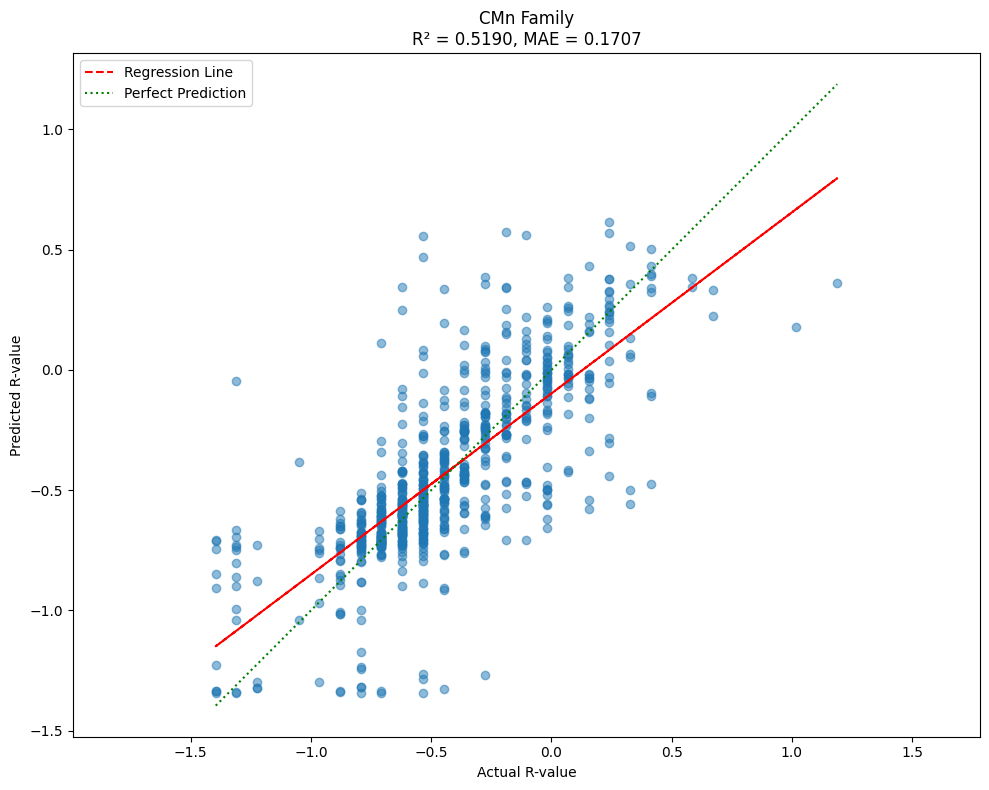

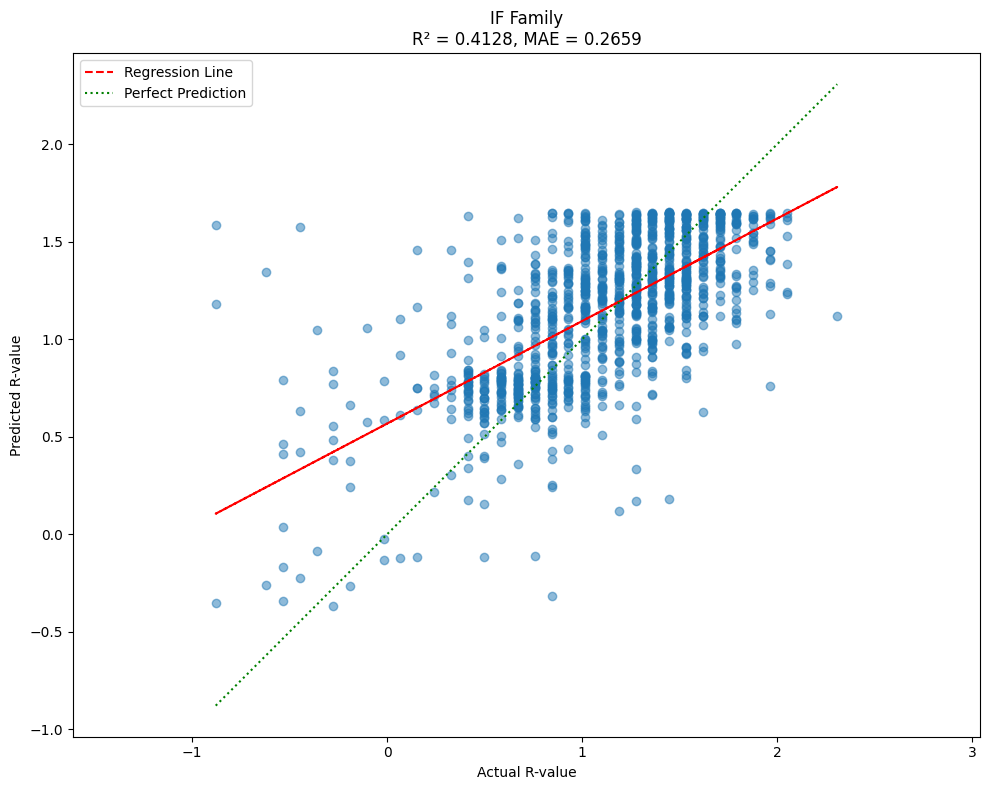

In [ ]:
plot_actual_vs_predicted(test_scaled_df, family_models_enhanced, features_dict)